In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [10]:
feats = [col for col in df.columns if "mfcc" in col]
feats += ['target', 'h_target', 'fold']
df = df[feats]

In [11]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,mfcc_11_pp_noise,mfcc_12_pp_std,mfcc_12_pp_mean,mfcc_12_pp_noise,mfcc_13_pp_std,mfcc_13_pp_mean,mfcc_13_pp_noise,target,h_target,fold
count,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000,...,3.094700e+04,3.094700e+04,3.094700e+04,3.094700e+04,3.094700e+04,30947.000000,30947.000000,30947.000000,30947.000000,30947.000000
mean,73.719667,46.264479,38.909376,33.446607,30.420424,30.067026,29.524960,29.485805,29.035557,28.434550,...,-1.094828e-02,-8.716480e-03,-9.601115e-03,-8.845765e-03,-1.555399e-02,0.040776,0.059854,24.927586,0.676673,5.471936
std,30.473942,18.374510,17.074185,14.922491,14.885459,15.237449,15.111426,15.600575,15.600374,15.252728,...,2.726516e-01,2.736618e-01,2.677122e-01,2.676037e-01,2.864968e-01,0.241262,0.221090,14.392002,0.467754,2.889230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.822421e+00,-1.743550e+00,-1.785658e+00,-1.961132e+00,-1.091179e+00,-0.816324,-0.856459,0.000000,0.000000,1.000000
25%,54.270596,34.628251,27.134954,22.152604,17.779317,16.509955,16.142753,15.170072,14.981445,14.189170,...,-1.762883e-01,-1.783273e-01,-1.762862e-01,-1.741768e-01,-1.953888e-01,-0.103663,-0.067070,12.000000,0.000000,3.000000
50%,74.850493,46.716638,38.133677,33.581847,30.752174,30.586093,30.338455,30.395567,30.146264,29.760050,...,-2.749787e-09,-2.322079e-09,-2.310073e-09,-2.205912e-09,1.642290e-09,0.008334,0.028113,25.000000,1.000000,5.000000
75%,93.894152,58.166543,50.129512,44.366403,41.731754,42.094875,41.359002,41.674235,40.984961,40.346104,...,1.474374e-01,1.507385e-01,1.474394e-01,1.499125e-01,1.652649e-01,0.208445,0.220185,38.000000,1.000000,8.000000
max,208.957500,123.849951,118.728586,92.085252,89.965195,89.935857,113.100970,118.224343,120.085079,113.077150,...,1.877341e+00,1.873430e+00,1.714011e+00,1.808934e+00,3.831676e+00,0.916364,0.846622,49.000000,1.000000,10.000000


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

In [14]:
train_X, train_y = balanced_subsample(train_X, train_y)

# Training

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=72)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5, n_jobs=10)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'n_neighbors': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6696170520231214
Confusion matrix, without normalization
[[1188  639]
 [1190 2519]]


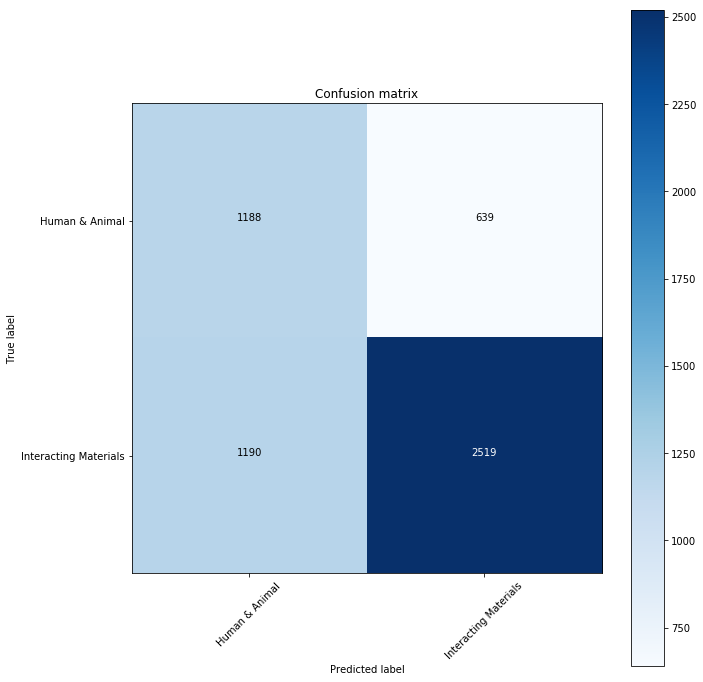

In [17]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [18]:
all_df = df[df.fold == 1]

In [19]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,mfcc_11_pp_noise,mfcc_12_pp_std,mfcc_12_pp_mean,mfcc_12_pp_noise,mfcc_13_pp_std,mfcc_13_pp_mean,mfcc_13_pp_noise,target,h_target,fold
420,111.596866,86.615622,61.087441,33.865777,15.158350,13.475249,20.481796,21.066811,17.346539,13.273112,...,-6.550727e-02,6.671280e-02,-3.458707e-02,-1.340016e-02,1.645734e-01,1.702055e-01,-1.684520e-01,8,0,1
421,80.110736,64.034686,39.159114,23.134286,10.522370,11.855999,17.952194,18.423541,9.308739,11.168965,...,6.629641e-09,-2.576086e-09,-3.587155e-09,1.174313e-09,3.311668e-09,5.904392e-09,-5.380382e-09,8,0,1
422,81.579264,55.893051,42.637125,31.437528,15.679350,13.377700,18.704595,16.808341,19.901737,11.469115,...,-3.766678e-09,-4.889906e-09,-7.622188e-09,-5.076802e-09,3.024119e-09,-6.283065e-09,-2.731208e-09,8,0,1
423,77.690120,61.920766,45.867028,26.040175,10.477979,2.896780,12.893714,14.912961,13.665269,10.299474,...,-5.015657e-10,-1.192390e-09,-1.446344e-09,1.392787e-09,-2.503511e-09,-2.808099e-09,3.516417e-09,8,0,1
424,51.782537,40.988090,30.560258,16.857580,5.897617,3.288289,9.032810,10.916167,9.586067,5.211155,...,5.108420e-01,-7.278034e-01,1.556858e-01,5.832338e-01,-3.006891e-01,3.072744e-01,-2.210013e-01,8,0,1


In [20]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.6040391676866586
Confusion matrix, without normalization
[[ 595  450]
 [ 844 1379]]


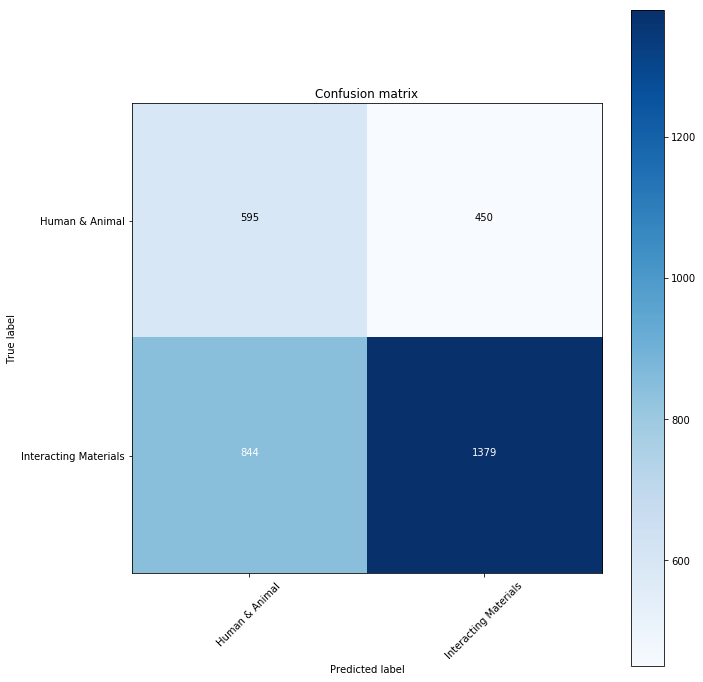

In [21]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [22]:
clf.best_estimator_ 

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

In [23]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Actual target'].append(classes[int(row[1]['target'])])
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [24]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.632257,0.367743
Interacting Materials,0.248333,0.751667


In [25]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.581250,0.418750
breathing,0.339286,0.660714
brushing_teeth,0.675000,0.325000
can_opening,0.631944,0.368056
car_horn,0.583333,0.416667
cat,0.278846,0.721154
chainsaw,0.614583,0.385417
chirping_birds,0.208904,0.791096
church_bells,0.569444,0.430556


In [26]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.666597,0.333403
Interacting Materials,0.220450,0.779550


In [27]:
average_prob = correctly_classified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.208333,0.791667
breathing,0.703125,0.296875
brushing_teeth,0.261029,0.738971
can_opening,0.312500,0.687500
car_horn,0.177419,0.822581
cat,0.726415,0.273585
chainsaw,0.225962,0.774038
chirping_birds,0.607955,0.392045
church_bells,0.233974,0.766026


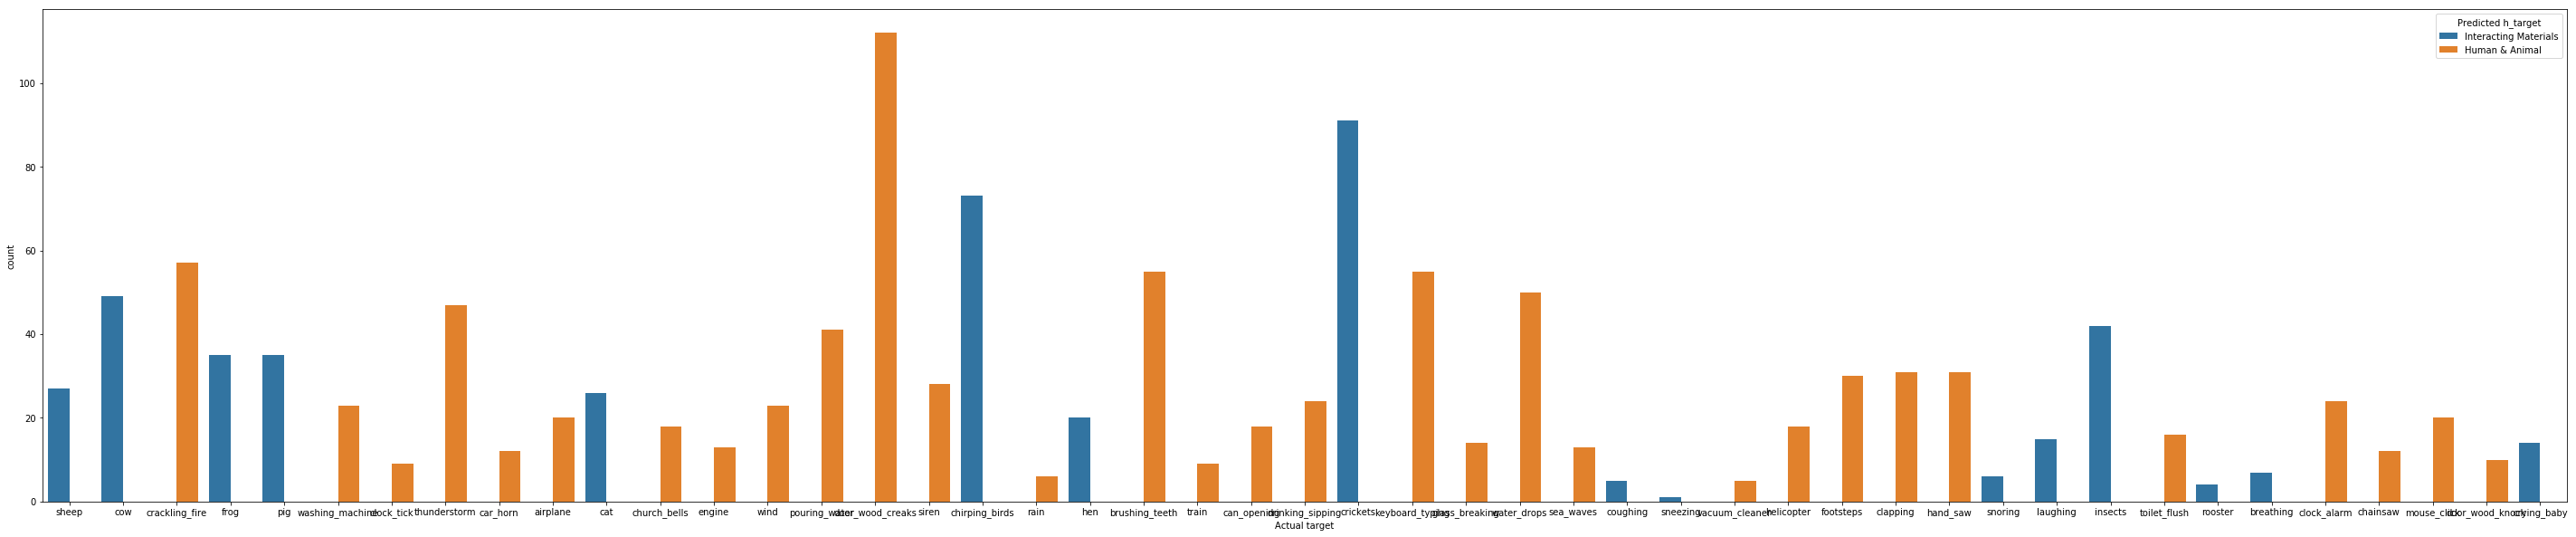

In [29]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)